# analyze $\pi$ vector form factor

$q=p-p'$  
$Q^2= - q^2$

$\langle P'(p')|V^{\mu}|P(p)\rangle = f_+(Q^2)(p+p')^\mu$

==============

 $P'$ is $\pi$ with p'  
 $P$ is $\pi$ with p

# lattice gauge ensemble properties
$32^3 \times 64$  
$m_\pi = 320$ MeV  
$a = 0.11403$ fm  
multiplicate renormalization factor: $Z_{V}=0.7903$  


In [1]:
Z_Vqq=0.7903
L=32

In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from lqcd.basic import *
from lqcd.jackknife import *

#temp
%load_ext autoreload
%autoreload 2



### preliminaries

In [3]:
def get_conf_list(fileloc):
    f=open(fileloc,"r")
    conf_list=[]
    for line in f:
        conf_list.append(int(line))
    print("N_konf:",len(conf_list))
    return conf_list

In [4]:
twopil = 2.*np.pi/float(L)

conf_list=get_conf_list("./conf.all")
Nkonf=len(conf_list)

N_konf: 6128


### definitions

In [5]:
with open('./event_list','rb') as ff2:
  event_list = pickle.load(ff2)
ff2.close()

## form factor analysis

![](img/ratio.png "Title")

In [8]:
#read the correlators
with open('./pion_cvE.pickle.8oba','rb') as ff1:
  pion_cv_E = pickle.load(ff1,encoding='latin1')
ff1.close()
with open('./pion_jE.pickle.8oba','rb') as ff1:
  pion_jack_E = pickle.load(ff1,encoding='latin1')
ff1.close()

In [9]:
#output of ratios
with open('./piJpi_cv_FF.8oba','rb') as ff1:
  cv_FF = pickle.load(ff1,encoding='latin1')
ff1.close()

with open('./piJpi_jack_FF.8oba','rb') as ff1:
  jack_FF = pickle.load(ff1,encoding='latin1')
ff1.close()

# how do the form factors look like

/home/leskovec/.conda/envs/lattice3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


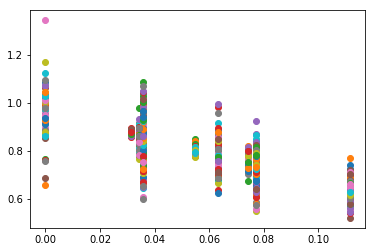

In [10]:
for zz in event_list:
    x=cv_FF[zz].Q2
    for nu in range(4):
        plt.plot(x,cv_FF[zz].ff[nu],marker='o')

In [11]:
sig_FF=rec_dd()
for i in range(len(event_list)):
  xx = event_list[i]
  tt,sig_FF[xx]=jack_stats_ff(conf_list,jack_FF[xx])


# averages over different directions, polarizations

In [12]:
#get events at same q2
def get_events_with_same_Q2(ff):
  a=[]
  for i in ff:
    a.append(ff[i].Q2)
  red_Q2=set(a)

  count=rec_dd()
  for j in red_Q2:
    count[str(j)]=[]
    for i in ff:
      if ff[i].Q2 == j:
        count[str(j)].append(i)
  return count


In [13]:
piV_Q2_bin=get_events_with_same_Q2(cv_FF)

reduced_event_list=[]

for qq in piV_Q2_bin.copy():
  zz = piV_Q2_bin[qq][0]
  reduced_event_list.append(zz)

In [14]:
av_cv_FF=rec_dd()
av_jack_FF=rec_dd()

for qq in piV_Q2_bin.copy():
  zz=piV_Q2_bin[qq][0]
  pi =  cv_FF[zz].pi
  pf =  cv_FF[zz].pf
  qc =  cv_FF[zz].Qc
  cQ2 = cv_FF[zz].Q2
  
  av_ctmpf = form_factor(pi,pf,qc)
  av_ctmpf.assign_Q2(cQ2)
    
  nper = 0
  tmp = 0.
  for xx in piV_Q2_bin[qq]:
    for idx in range(4):
      if cv_FF[xx].ff[idx]!=0:
        tmp += cv_FF[xx].ff[idx]
        nper += 1
  if nper != 0:
    av_ctmpf.assign_ff(tmp/nper,1)

  av_cv_FF[zz] = av_ctmpf
  
  for konf in conf_list:
    jQ2 = jack_FF[zz][konf].Q2

    av_jtmpf = form_factor(pi,pf,qc)
    av_jtmpf.assign_Q2(jQ2)
    
    nper = 0
    tmp = 0.
    for xx in piV_Q2_bin[qq]:
      for idx in range(4):
        if jack_FF[xx][konf]!=0:
          tmp += jack_FF[xx][konf].ff[idx]
          nper += 1
    if nper!=0:
      av_jtmpf.assign_ff(tmp/nper,1)

    av_jack_FF[zz][konf] = av_jtmpf


In [15]:
sig_av_FF = rec_dd()
for zz in reduced_event_list:
  tt,sig_av_FF[zz]=jack_stats_ff(conf_list,av_jack_FF[zz])

(-0.02, 0.13)

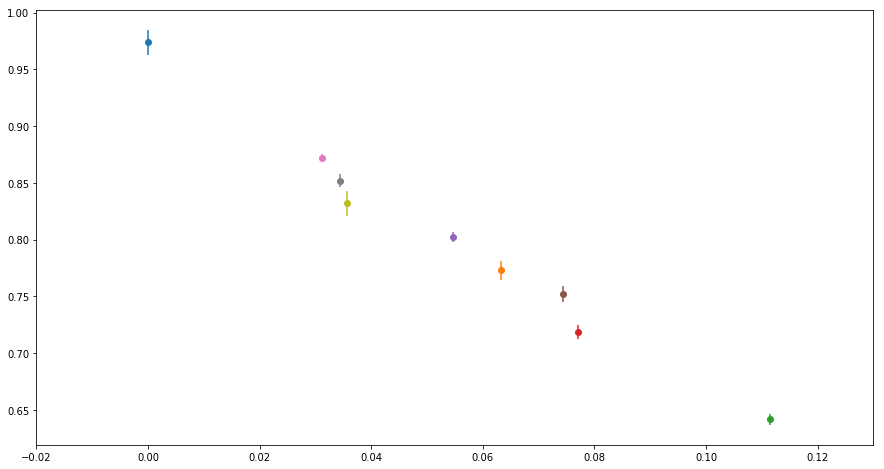

In [16]:
plt.figure(figsize=(15,8))
for zz in reduced_event_list:
  x=cv_FF[zz].Q2
  plt.errorbar(x,av_cv_FF[zz].ff[1].real,sig_av_FF[zz].ff[1].real,marker='o')
plt.xlim(-0.02,0.13)


# now let's fit it

In [17]:
Q2=np.zeros(len(reduced_event_list))

cv_f=np.zeros(len(reduced_event_list))
jack_f=np.zeros((len(reduced_event_list),Nkonf))
sig_f=np.zeros(len(reduced_event_list))

iq=0
for qq in piV_Q2_bin.copy():
  zz=piV_Q2_bin[qq][0]
  Q2[iq]=av_cv_FF[zz].Q2
  cv_f[iq]=av_cv_FF[zz].ff[1].real
  sig_f[iq]=sig_av_FF[zz].ff[1].real
  for ik in range(len(conf_list)):
    konf=conf_list[ik]
    jack_f[iq,ik]=av_jack_FF[zz][konf].ff[1].real
  iq+=1


In [18]:
def f_lin(x,A,B):
  return A+B*x

In [19]:
cv_p, tt = curve_fit(f_lin, Q2, cv_f, sigma=sig_f, absolute_sigma=True)
cv_A=cv_p[0]
cv_B=cv_p[1]
jack_p=np.zeros((2,Nkonf))
for ik in range(len(conf_list)):
  jack_p[:,ik],tt=curve_fit(f_lin, Q2, jack_f[:,ik], sigma=sig_f, absolute_sigma=True)

In [20]:
theta_A,sig_A=jack_sigma_scalar(jack_p[0,:])
theta_B,sig_B=jack_sigma_scalar(jack_p[1,:])

In [21]:
print('linear fit to A+B*x:')
print('A: ', cv_p[0],'±',sig_A)
print('B: ', cv_p[1],'±',sig_B)

linear fit to A+B*x:
A:  0.9594206903730407 ± 0.004503031709680002
B:  -2.899009140727555 ± 0.0468592708225746


In [22]:
N=300
ss=np.linspace(-0.02,0.13,num=N)
jack_lin_sig=np.zeros((N,Nkonf))
theta_lin_sig=np.zeros((N))
cv_lin_sig=np.zeros((N))
sig_lin_sig=np.zeros((N))

cv_lin_sig=f_lin(ss,cv_p[0],cv_p[1])

for konf in range(Nkonf):
  jack_lin_sig[:,konf]=f_lin(ss,jack_p[0,konf],jack_p[1,konf])

for i in range(N):
  theta_lin_sig[i],sig_lin_sig[i]=jack_sigma_scalar(jack_lin_sig[i,:])

Text(0.1,0.8,'fit: $f_+(Q^2) = A + B (aQ)^2$ \n A(dA): 0.9594(0.0045)\n B(dB): -2.8990(0.0469)')

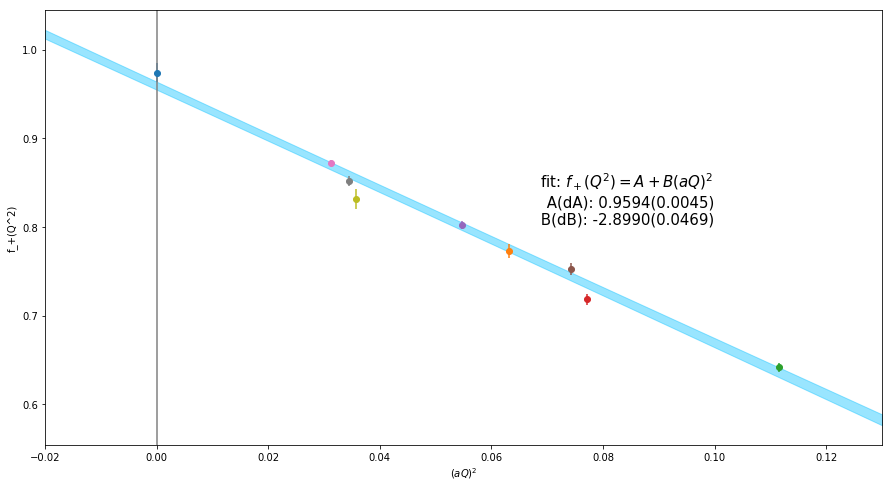

In [23]:
plt.figure(figsize=(15,8))
plt.fill_between(ss,cv_lin_sig - sig_lin_sig,cv_lin_sig + sig_lin_sig,alpha=0.4,color='deepskyblue')
for zz in reduced_event_list:
  x=cv_FF[zz].Q2
  plt.errorbar(x,av_cv_FF[zz].ff[1].real,sig_av_FF[zz].ff[1].real,marker='o')
  
plt.xlim(-0.02,0.13)
plt.axvline(0,color='gray')
plt.xlabel("$(aQ)^2$")
plt.ylabel("f_+(Q^2)")

textstring = "fit: $f_+(Q^2) = A + B (aQ)^2$ \n A(dA): {0:6.4f}({1:6.4f})\n B(dB): {2:6.4f}({3:6.4f})".format(cv_A,sig_A,cv_B,sig_B)
plt.text(0.1, 0.8,textstring,verticalalignment='bottom', 
         horizontalalignment='right',color='black', fontsize=15)

# radius

$f_+(Q^2) = 1 - \frac{1}{6} r^2 Q^2$

In [24]:
#set the scale - this time lattice spacing is a=0.11403 fm
a=0.11403
ainv=set_scale(a)

In [25]:
lattice_R2_cv = -6.0*cv_B
lattice_R2_sig = 6.0*sig_B

print("r^2 in lattice units: {0:5.3f} +- {1:5.3f}".format(lattice_R2_cv,lattice_R2_sig))

print("r^2 in fm^2: {0:5.3f} +- {1:5.3f}".format(lattice_R2_cv*a*a,lattice_R2_sig*a*a))
print("r in fm: {0:5.3f} +- {1:5.3f}".format(np.sqrt(lattice_R2_cv*a*a),np.sqrt(lattice_R2_sig*a*a)))


r^2 in lattice units: 17.394 +- 0.281
r^2 in fm^2: 0.226 +- 0.004
r in fm: 0.476 +- 0.060


# just for fun - what $Q^2$ range can we reach

Text(0,0.5,'f_+(Q^2)')

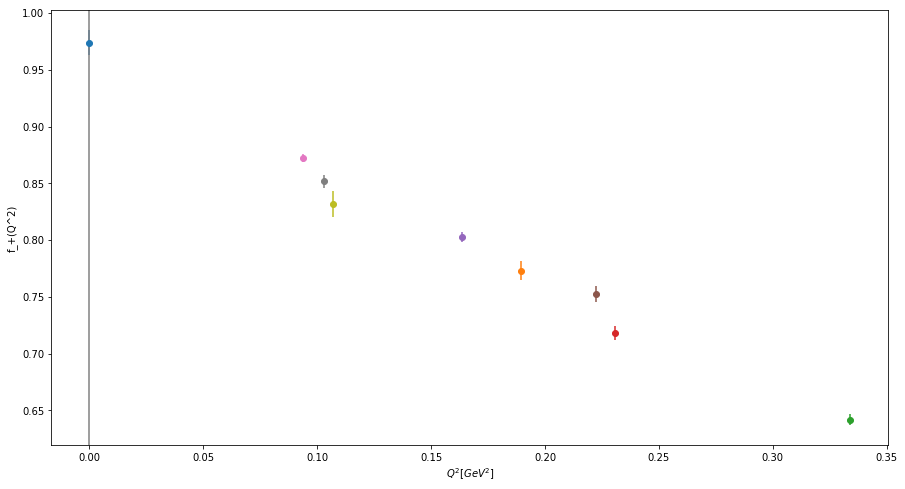

In [26]:
plt.figure(figsize=(15,8))
for zz in reduced_event_list:
    x=cv_FF[zz].Q2*ainv*ainv/(1000*1000)
    plt.errorbar(x,av_cv_FF[zz].ff[1].real,sig_av_FF[zz].ff[1].real,marker='o')
  
plt.axvline(0,color='gray')
plt.xlabel("$Q^2 [GeV^2]$")
plt.ylabel("f_+(Q^2)")
